# MNIST database of Handwritten Digits

Here I'm going to compare the results of two Neural Networks to classify the MNIST database of handwritten digits. The first one is a simple Neural Network with multiple layers and the second one is a Convolutional Neural Network (CNN).


In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import warnings
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
warnings.filterwarnings('ignore')


## Reading the data

In [2]:
# To load the MNIST dataset without download external files
from tensorflow.keras.datasets import mnist


In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


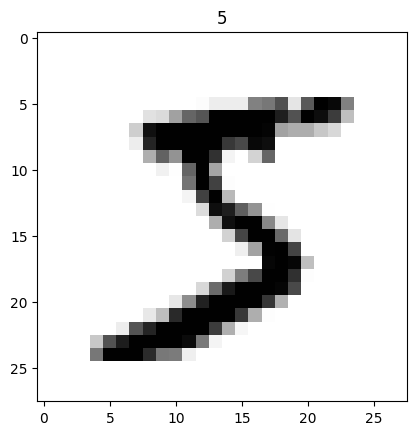

In [9]:
plt.imshow(X_train[0], cmap='binary')
plt.title(y_train[0]);


In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Neural Network

### Flattenning the image data and normalizing it

In [20]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train /= 255
X_test /= 255


In [29]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


### Building the model's architecture

In [22]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=128,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=128,
        shuffle=True
    )
}


In [25]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], output_size),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.linear_stack(x)


In [26]:
model = NeuralNet(X_train.shape[1], [100, 64, 32], 10)
optimizer = optim.Adam(model.parameters(), lr=1.5e-3)
loss_fn = nn.CrossEntropyLoss()
model


NeuralNet(
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)

In [ ]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
best_model = None

epochs = 1000

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()  
        output = model(data)   
        loss = loss_fn(output, target)  
        loss.backward() 
        optimizer.step()  

        acc = (output.argmax(dim=1) == target).float().mean()  
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model.eval()
    test_loss = []
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            test_loss.append(loss_fn(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum()

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(np.mean(test_loss))
    test_acc_hist.append(correct / len(loaders['test'].dataset))

    if best_acc < (correct / len(loaders['test'].dataset)):
        best_acc = (correct / len(loaders['test'].dataset))
        best_model = copy.deepcopy(model)

    if (correct / len(loaders['test'].dataset) >= 0.997) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 200:
        if np.mean(test_acc_hist[-75:]) <= np.mean(test_acc_hist[-150:-75]):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n")


  0%|          | 0/469000 [00:00<?, ?it/s]

Epoch [6/1000]:   1%|          | 2379/469000 [00:13<58:38, 132.60it/s, loss=1.502069]  

 Test set: Average loss: 1.5057, Accuracy: 9566/10000 (95.66%)



Epoch [11/1000]:   1%|          | 4721/469000 [00:25<47:19, 163.51it/s, loss=1.481169]

 Test set: Average loss: 1.4954, Accuracy: 9682/10000 (96.82%)



Epoch [16/1000]:   2%|▏         | 7073/469000 [00:37<43:52, 175.50it/s, loss=1.498763]

 Test set: Average loss: 1.4919, Accuracy: 9696/10000 (96.96%)



Epoch [21/1000]:   2%|▏         | 9419/469000 [00:50<42:02, 182.19it/s, loss=1.461150]  

 Test set: Average loss: 1.4889, Accuracy: 9719/10000 (97.19%)



Epoch [26/1000]:   3%|▎         | 11764/469000 [01:02<46:20, 164.43it/s, loss=1.469289]  

 Test set: Average loss: 1.4871, Accuracy: 9743/10000 (97.43%)



Epoch [31/1000]:   3%|▎         | 14101/469000 [01:15<46:31, 162.96it/s, loss=1.484303]  

 Test set: Average loss: 1.4869, Accuracy: 9735/10000 (97.35%)



Epoch [36/1000]:   4%|▎         | 16443/469000 [01:27<51:22, 146.80it/s, loss=1.476794]

 Test set: Average loss: 1.4879, Accuracy: 9730/10000 (97.30%)



Epoch [41/1000]:   4%|▍         | 18795/469000 [01:40<46:29, 161.39it/s, loss=1.468975]

 Test set: Average loss: 1.4882, Accuracy: 9728/10000 (97.28%)



Epoch [46/1000]:   5%|▍         | 21139/469000 [01:53<45:43, 163.22it/s, loss=1.461150]

 Test set: Average loss: 1.4853, Accuracy: 9765/10000 (97.65%)



Epoch [51/1000]:   5%|▌         | 23484/469000 [02:07<48:20, 153.62it/s, loss=1.461150]

 Test set: Average loss: 1.4854, Accuracy: 9754/10000 (97.54%)



Epoch [56/1000]:   6%|▌         | 25828/469000 [02:21<46:11, 159.93it/s, loss=1.461437]

 Test set: Average loss: 1.4903, Accuracy: 9721/10000 (97.21%)



Epoch [61/1000]:   6%|▌         | 28168/469000 [02:35<53:34, 137.15it/s, loss=1.476269]  

 Test set: Average loss: 1.4857, Accuracy: 9748/10000 (97.48%)



Epoch [66/1000]:   7%|▋         | 30508/469000 [02:50<58:18, 125.35it/s, loss=1.476714]

 Test set: Average loss: 1.4878, Accuracy: 9730/10000 (97.30%)



Epoch [71/1000]:   7%|▋         | 32863/469000 [03:05<48:43, 149.17it/s, loss=1.483347]  

 Test set: Average loss: 1.4862, Accuracy: 9747/10000 (97.47%)



Epoch [76/1000]:   8%|▊         | 35207/469000 [03:19<47:14, 153.07it/s, loss=1.468959]

 Test set: Average loss: 1.4878, Accuracy: 9731/10000 (97.31%)



Epoch [81/1000]:   8%|▊         | 37550/469000 [03:33<52:42, 136.44it/s, loss=1.461150]

 Test set: Average loss: 1.4841, Accuracy: 9768/10000 (97.68%)



Epoch [86/1000]:   9%|▊         | 39897/469000 [03:48<49:53, 143.36it/s, loss=1.461150]  

 Test set: Average loss: 1.4867, Accuracy: 9742/10000 (97.42%)



Epoch [91/1000]:   9%|▉         | 42242/469000 [04:03<48:39, 146.20it/s, loss=1.476392]  

 Test set: Average loss: 1.4855, Accuracy: 9753/10000 (97.53%)



Epoch [96/1000]:  10%|▉         | 44586/469000 [04:17<48:55, 144.60it/s, loss=1.461150]

 Test set: Average loss: 1.4901, Accuracy: 9709/10000 (97.09%)



Epoch [101/1000]:  10%|█         | 46930/469000 [04:31<46:53, 150.04it/s, loss=1.468963] 

 Test set: Average loss: 1.4861, Accuracy: 9754/10000 (97.54%)



Epoch [106/1000]:  11%|█         | 49273/469000 [04:46<46:38, 150.00it/s, loss=1.461150]

 Test set: Average loss: 1.4843, Accuracy: 9766/10000 (97.66%)



Epoch [111/1000]:  11%|█         | 51622/469000 [05:00<47:14, 147.24it/s, loss=1.492402]

 Test set: Average loss: 1.4883, Accuracy: 9724/10000 (97.24%)



Epoch [116/1000]:  12%|█▏        | 53956/469000 [05:14<47:14, 146.41it/s, loss=1.484588]

 Test set: Average loss: 1.4932, Accuracy: 9682/10000 (96.82%)



Epoch [121/1000]:  12%|█▏        | 56313/469000 [05:28<44:23, 154.95it/s, loss=1.461269]

 Test set: Average loss: 1.4852, Accuracy: 9757/10000 (97.57%)



Epoch [126/1000]:  13%|█▎        | 58659/469000 [05:42<47:23, 144.31it/s, loss=1.484559]

 Test set: Average loss: 1.4883, Accuracy: 9724/10000 (97.24%)



Epoch [131/1000]:  13%|█▎        | 61002/469000 [05:56<44:13, 153.77it/s, loss=1.484826]

 Test set: Average loss: 1.4862, Accuracy: 9746/10000 (97.46%)



Epoch [136/1000]:  14%|█▎        | 63347/469000 [06:10<42:54, 157.58it/s, loss=1.488097]

 Test set: Average loss: 1.4887, Accuracy: 9727/10000 (97.27%)



Epoch [141/1000]:  14%|█▍        | 65692/469000 [06:24<44:02, 152.63it/s, loss=1.461150]

 Test set: Average loss: 1.4851, Accuracy: 9758/10000 (97.58%)



Epoch [146/1000]:  15%|█▍        | 68038/469000 [06:38<47:25, 140.92it/s, loss=1.468963]

 Test set: Average loss: 1.4849, Accuracy: 9758/10000 (97.58%)



Epoch [151/1000]:  15%|█▌        | 70383/469000 [06:52<43:13, 153.69it/s, loss=1.461427]

 Test set: Average loss: 1.4850, Accuracy: 9758/10000 (97.58%)



Epoch [156/1000]:  16%|█▌        | 72725/469000 [07:11<52:57, 124.72it/s, loss=1.468972]  

 Test set: Average loss: 1.4894, Accuracy: 9714/10000 (97.14%)



Epoch [161/1000]:  16%|█▌        | 75052/469000 [07:27<59:52, 109.66it/s, loss=1.468963]  

 Test set: Average loss: 1.4866, Accuracy: 9741/10000 (97.41%)



Epoch [166/1000]:  17%|█▋        | 77415/469000 [07:43<44:58, 145.09it/s, loss=1.468963] 

 Test set: Average loss: 1.4862, Accuracy: 9746/10000 (97.46%)



Epoch [171/1000]:  17%|█▋        | 79758/469000 [07:59<46:03, 140.86it/s, loss=1.461150]  

 Test set: Average loss: 1.4846, Accuracy: 9761/10000 (97.61%)



Epoch [176/1000]:  18%|█▊        | 82102/469000 [08:14<47:27, 135.89it/s, loss=1.484587]  

 Test set: Average loss: 1.4862, Accuracy: 9747/10000 (97.47%)



Epoch [181/1000]:  18%|█▊        | 84447/469000 [08:29<45:32, 140.72it/s, loss=1.469078]

 Test set: Average loss: 1.4863, Accuracy: 9744/10000 (97.44%)



Epoch [186/1000]:  19%|█▊        | 86795/469000 [08:45<46:33, 136.80it/s, loss=1.461150]

 Test set: Average loss: 1.4860, Accuracy: 9749/10000 (97.49%)



Epoch [191/1000]:  19%|█▉        | 89143/469000 [08:59<39:27, 160.42it/s, loss=1.484588]

 Test set: Average loss: 1.4846, Accuracy: 9763/10000 (97.63%)



Epoch [196/1000]:  20%|█▉        | 91487/469000 [09:14<43:25, 144.91it/s, loss=1.484583]

 Test set: Average loss: 1.4891, Accuracy: 9724/10000 (97.24%)



Epoch [201/1000]:  20%|██        | 93833/469000 [09:29<48:19, 129.40it/s, loss=1.461150]

 Test set: Average loss: 1.4877, Accuracy: 9731/10000 (97.31%)



Epoch [206/1000]:  21%|██        | 96178/469000 [09:44<43:35, 142.53it/s, loss=1.468963]

 Test set: Average loss: 1.4875, Accuracy: 9733/10000 (97.33%)



Epoch [211/1000]:  21%|██        | 98523/469000 [10:00<41:25, 149.03it/s, loss=1.461150]

 Test set: Average loss: 1.4824, Accuracy: 9792/10000 (97.92%)



Epoch [216/1000]:  22%|██▏       | 100866/469000 [10:16<43:46, 140.14it/s, loss=1.468963] 

 Test set: Average loss: 1.4881, Accuracy: 9727/10000 (97.27%)



Epoch [221/1000]:  22%|██▏       | 103212/469000 [10:30<38:00, 160.37it/s, loss=1.468963]

 Test set: Average loss: 1.4869, Accuracy: 9739/10000 (97.39%)



Epoch [226/1000]:  23%|██▎       | 105557/469000 [10:44<38:33, 157.08it/s, loss=1.476775]

 Test set: Average loss: 1.4836, Accuracy: 9772/10000 (97.72%)



Epoch [231/1000]:  23%|██▎       | 107901/469000 [10:58<41:25, 145.27it/s, loss=1.476775]

 Test set: Average loss: 1.4880, Accuracy: 9728/10000 (97.28%)



Epoch [236/1000]:  24%|██▎       | 110244/469000 [11:14<47:17, 126.44it/s, loss=1.461150] 

 Test set: Average loss: 1.4861, Accuracy: 9755/10000 (97.55%)



Epoch [241/1000]:  24%|██▍       | 112591/469000 [11:28<41:57, 141.57it/s, loss=1.484588]

 Test set: Average loss: 1.4860, Accuracy: 9749/10000 (97.49%)



Epoch [246/1000]:  25%|██▍       | 114937/469000 [11:42<37:31, 157.22it/s, loss=1.468963]

 Test set: Average loss: 1.4886, Accuracy: 9729/10000 (97.29%)



Epoch [247/1000]:  25%|██▍       | 115842/469000 [11:47<33:31, 175.54it/s, loss=1.513234]


Accuraccy of test set is not improving. Finishing training...

Accuracy: 9727/10000 (97.27%)



Epoch [247/1000]:  25%|██▍       | 115843/469000 [12:00<33:31, 175.54it/s, loss=1.513234]

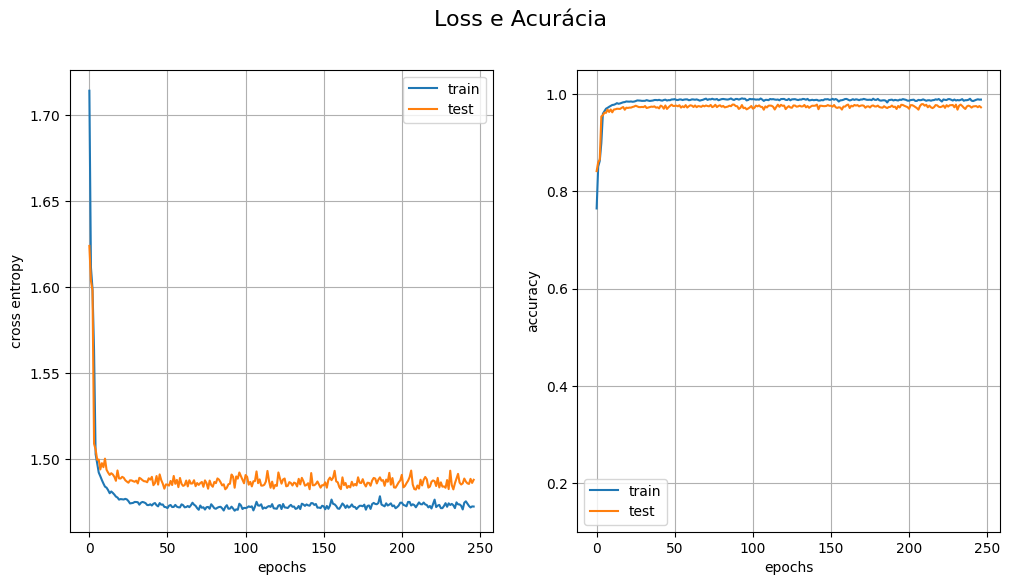

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_ylim(.1, 1.05)
ax[1].grid();
fig.suptitle("Loss e Acurácia", fontsize=16);


In [31]:
best_model.eval()
with torch.no_grad():
    output = best_model(X_train)

pred = np.argmax(output.numpy(), axis=1)
print(f"Errors: {sum(pred != y_train.numpy())} / {len(pred)}")
print(f"Training Accuracy: {100. * (1 - sum(pred != y_train.numpy()) / len(pred)):.2f}%")


Errors: 556 / 60000
Training Accuracy: 99.07%


In [34]:
best_model.eval()
with torch.no_grad():
    output = best_model(X_test)

pred = np.argmax(output.numpy(), axis=1)
print(f"Errors: {sum(pred != y_test.numpy())} / {len(pred)}")
print(f"Test Accuracy: {100. * (1 - sum(pred != y_test.numpy()) / len(pred)):.2f}%")


Errors: 208 / 10000
Test Accuracy: 97.92%


In [ ]:
n = len(pd.unique(y_test.numpy()))
y_true = np.array(y_test.numpy())
y_pred = np.array(pred)

matriz = np.zeros((n, n), dtype=int)

for id, i in enumerate(list(range(10))):
    for jd, j in enumerate(list(range(10))):
        matriz[id][jd] = np.sum((y_true == i) & (y_pred == j))


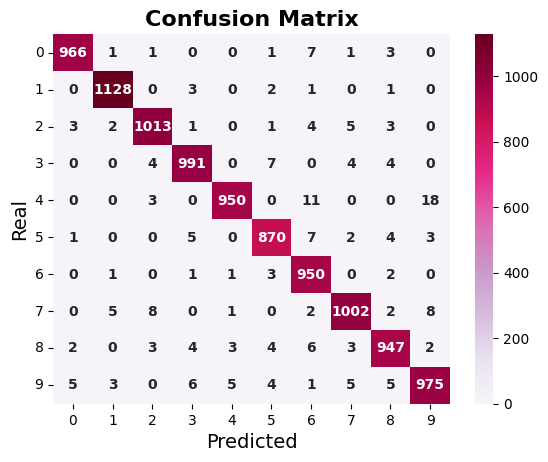

In [ ]:
sns.heatmap(matriz,
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(10)),
                yticklabels=list(range(10)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


In [ ]:
from collections import Counter

Counter(y_test.numpy())


Counter({1: 1135,
         2: 1032,
         7: 1028,
         3: 1010,
         9: 1009,
         4: 982,
         0: 980,
         8: 974,
         6: 958,
         5: 892})

## Convolutional Neural Network (CNN)

### Reading the images and normalizing them

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train /= 255
X_test /= 255


In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [5]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=128,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=128,
        shuffle=True
    )
}


In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.linear_stack = nn.Sequential(
            #  (Number of Channels) x (Height) x (Width)
            nn.Linear(16 * 11 * 11, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.linear_stack(x)
        return x


About this architecture is important to say that image size is everytime getting smaller, because on the first Convolutional Layer, I'm using ```kernel_size=5``` and ```padding=0```, so the result of this convolution is 28(original) - 5(kernel size) + 1 = __24__, so is 24x24 matrix. Then, on the another Convolutional Layer, we do the operation with ```kernel_size=3``` and ```stride=2```, so the result of this convolution is (24(input result from previous convolution) - 3(kernel size) + 1) / 2(stride) = __11__. So the result from the Convolutional part of this CNN is 11x11 matrix, and as on the last convolution the result is with 16 channels, the input size of the Linear layer is 16x11x11 (Number of Channels) x (Height) x (Width).

In [7]:
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=1.5e-3)
loss_fn = nn.CrossEntropyLoss()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cuda


ConvNet(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=1936, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [60]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
best_model = None

epochs = 1000

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model.train()
    for data, target in loaders['train']:
        optimizer.zero_grad() 
        data = data.unsqueeze(1).to(device)
        output = model(data)  
        loss = loss_fn(output, target.to(device)) 
        loss.backward() 
        optimizer.step() 

        acc = (output.argmax(dim=1) == target.to(device)).float().mean() 
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.cpu())

        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model.eval()
    test_loss = []
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.unsqueeze(1).to(device)
            output = model(data)
            
            test_loss.append(loss_fn(output, target.to(device)).item())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred).to(device)).sum()

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(np.mean(test_loss))
    test_acc_hist.append(correct.cpu() / len(loaders['test'].dataset))

    if best_acc < (correct / len(loaders['test'].dataset)):
        best_acc = (correct / len(loaders['test'].dataset))
        best_model = copy.deepcopy(model)

    if (correct / len(loaders['test'].dataset) >= 0.997) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 120:
        if np.mean(test_acc_hist[-50:]) <= np.mean(test_acc_hist[-100:-50]):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n")


Epoch [6/1000]:   1%|          | 2356/469000 [00:26<6:11:05, 20.96it/s, loss=0.149989]

 Test set: Average loss: 0.0421, Accuracy: 9884/10000 (98.84%)



Epoch [11/1000]:   1%|          | 4702/469000 [00:51<2:08:59, 59.99it/s, loss=0.090552]

 Test set: Average loss: 0.0394, Accuracy: 9890/10000 (98.90%)



Epoch [16/1000]:   2%|▏         | 7053/469000 [01:16<1:37:07, 79.27it/s, loss=0.037927]

 Test set: Average loss: 0.0393, Accuracy: 9898/10000 (98.98%)



Epoch [21/1000]:   2%|▏         | 9400/469000 [01:39<1:33:08, 82.24it/s, loss=0.068810]

 Test set: Average loss: 0.0425, Accuracy: 9909/10000 (99.09%)



Epoch [26/1000]:   3%|▎         | 11746/469000 [02:02<1:31:38, 83.16it/s, loss=0.080611]

 Test set: Average loss: 0.0449, Accuracy: 9907/10000 (99.07%)



Epoch [31/1000]:   3%|▎         | 14088/469000 [02:25<1:44:32, 72.52it/s, loss=0.072934]

 Test set: Average loss: 0.0527, Accuracy: 9897/10000 (98.97%)



Epoch [36/1000]:   4%|▎         | 16434/469000 [02:48<1:33:42, 80.49it/s, loss=0.040281]

 Test set: Average loss: 0.0489, Accuracy: 9901/10000 (99.01%)



Epoch [41/1000]:   4%|▍         | 18780/469000 [03:11<1:34:01, 79.80it/s, loss=0.081644]

 Test set: Average loss: 0.0521, Accuracy: 9885/10000 (98.85%)



Epoch [46/1000]:   5%|▍         | 21123/469000 [03:34<1:49:33, 68.13it/s, loss=0.087743]

 Test set: Average loss: 0.0594, Accuracy: 9891/10000 (98.91%)



Epoch [51/1000]:   5%|▌         | 23472/469000 [03:57<1:39:51, 74.36it/s, loss=0.043780]

 Test set: Average loss: 0.0552, Accuracy: 9904/10000 (99.04%)



Epoch [56/1000]:   6%|▌         | 25814/469000 [04:20<1:45:07, 70.27it/s, loss=0.043442]

 Test set: Average loss: 0.0527, Accuracy: 9907/10000 (99.07%)



Epoch [61/1000]:   6%|▌         | 28160/469000 [04:46<1:27:13, 84.24it/s, loss=0.065899]

 Test set: Average loss: 0.0542, Accuracy: 9910/10000 (99.10%)



Epoch [66/1000]:   7%|▋         | 30507/469000 [05:10<1:26:39, 84.33it/s, loss=0.066664]

 Test set: Average loss: 0.0552, Accuracy: 9893/10000 (98.93%)



Epoch [71/1000]:   7%|▋         | 32852/469000 [05:33<1:26:03, 84.47it/s, loss=0.053633]

 Test set: Average loss: 0.0544, Accuracy: 9900/10000 (99.00%)



Epoch [76/1000]:   8%|▊         | 35196/469000 [05:55<1:22:06, 88.06it/s, loss=0.031138]

 Test set: Average loss: 0.0658, Accuracy: 9894/10000 (98.94%)



Epoch [81/1000]:   8%|▊         | 37538/469000 [06:17<1:34:13, 76.32it/s, loss=0.046724]

 Test set: Average loss: 0.0713, Accuracy: 9890/10000 (98.90%)



Epoch [86/1000]:   9%|▊         | 39886/469000 [06:39<1:34:46, 75.46it/s, loss=0.055644]

 Test set: Average loss: 0.0648, Accuracy: 9902/10000 (99.02%)



Epoch [91/1000]:   9%|▉         | 42231/469000 [07:01<1:24:34, 84.10it/s, loss=0.037500]

 Test set: Average loss: 0.0777, Accuracy: 9889/10000 (98.89%)



Epoch [96/1000]:  10%|▉         | 44574/469000 [07:24<1:23:57, 84.25it/s, loss=0.021135]

 Test set: Average loss: 0.0691, Accuracy: 9902/10000 (99.02%)



Epoch [101/1000]:  10%|█         | 46918/469000 [07:46<1:32:08, 76.35it/s, loss=0.032784]

 Test set: Average loss: 0.0706, Accuracy: 9906/10000 (99.06%)



Epoch [106/1000]:  11%|█         | 49265/469000 [08:09<1:23:22, 83.91it/s, loss=0.045958]

 Test set: Average loss: 0.0730, Accuracy: 9904/10000 (99.04%)



Epoch [111/1000]:  11%|█         | 51610/469000 [08:32<1:28:39, 78.47it/s, loss=0.034464]

 Test set: Average loss: 0.0801, Accuracy: 9891/10000 (98.91%)



Epoch [116/1000]:  12%|█▏        | 53955/469000 [08:54<1:26:36, 79.86it/s, loss=0.076116]

 Test set: Average loss: 0.0703, Accuracy: 9898/10000 (98.98%)



Epoch [121/1000]:  12%|█▏        | 56300/469000 [09:17<1:22:14, 83.63it/s, loss=0.010060]

 Test set: Average loss: 0.0652, Accuracy: 9894/10000 (98.94%)



Epoch [121/1000]:  12%|█▏        | 56748/469000 [09:21<58:47, 116.85it/s, loss=0.046857]


Accuraccy of test set is not improving. Finishing training...

Accuracy: 9901/10000 (99.01%)



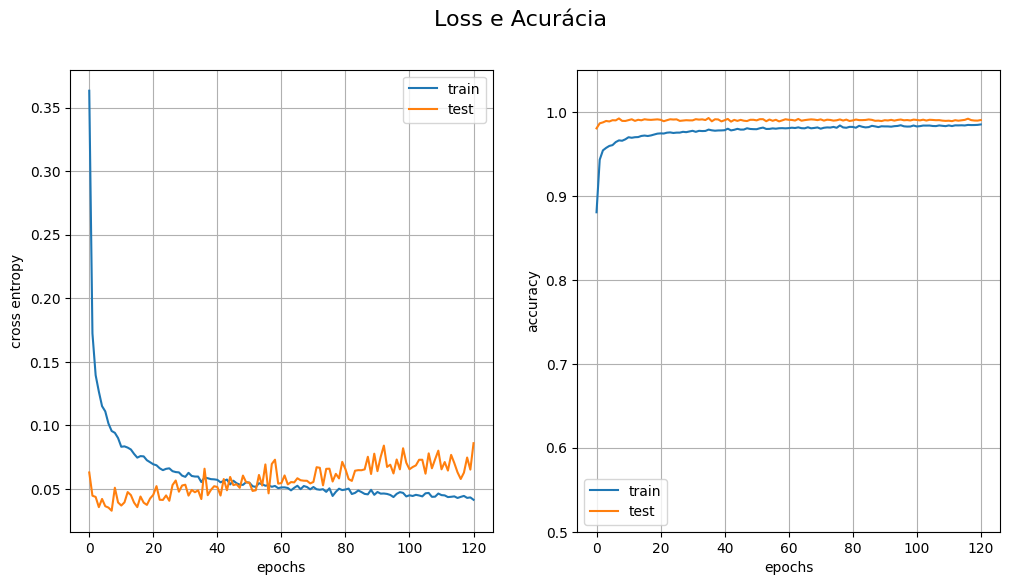

In [221]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_ylim(.5, 1.05)
ax[1].grid();
fig.suptitle("Loss e Acurácia", fontsize=16);
plt.show()


In [66]:
model.eval()
with torch.no_grad():
    output = model(X_train.unsqueeze(1).to(device))

pred = np.argmax(output.cpu(), axis=1)
print(f"Errors: {sum(pred != y_train.cpu())} / {len(pred)}")
print(f"Training Accuracy {100. * (1 - sum(pred != y_train.cpu()) / len(pred)):.2f}%")


Errors: 7 / 60000
Training Accuracy 99.99%


In [15]:
best_model.eval()
with torch.no_grad():
    output = best_model(X_test.unsqueeze(1).to(device))

pred = np.argmax(output.cpu(), axis=1)
print(f"Errors: {sum(pred != y_test.cpu())} / {len(pred)}")
print(f"Test Accuracy: {100. * (1 - sum(pred != y_test.cpu()) / len(pred)):.2f}%")


Errors: 99 / 10000
Test Accuracy: 99.01%


In [16]:
n = len(pd.unique(y_test.numpy()))
y_true = np.array(y_test.numpy())
y_pred = np.array(pred)

matriz = np.zeros((n, n), dtype=int)

for id, i in enumerate(list(range(10))):
    for jd, j in enumerate(list(range(10))):
        matriz[id][jd] = np.sum((y_true == i) & (y_pred == j))


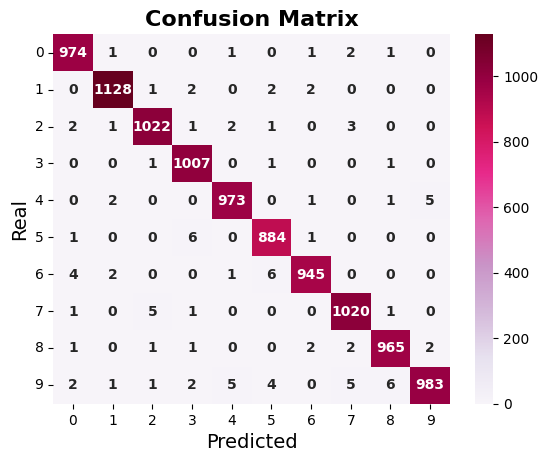

In [17]:
sns.heatmap(matriz,
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(10)),
                yticklabels=list(range(10)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


In [42]:
def visualize_filters(model, layer_name, num_filters=16, figsize=(10, 10)):
    layer = None
    for name, module in model.named_modules():
        if name.startswith('conv_stack'):
            if isinstance(module, torch.nn.Conv2d):
                layer = module
                break

    if layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    # Get the filter weights (kernels) from the layer
    filters = layer.weight.data

    # Ensure the number of filters to visualize does not exceed the actual number of filters in the layer
    num_filters = min(num_filters, filters.size(0))

    # Calculate the number of rows and columns for the grid
    rows = int(np.ceil(np.sqrt(num_filters)))
    cols = int(np.ceil(num_filters / rows))

    # Create a new figure
    plt.figure(figsize=figsize)

    # Plot each filter
    for i in range(num_filters):
        filter_weights = filters[i].cpu().numpy()

        # Normalize filter weights to [0, 1]
        filter_weights -= filter_weights.min()
        filter_weights /= filter_weights.max()

        plt.subplot(rows, cols, i + 1)
        plt.imshow(filter_weights[0], cmap='gray')
        plt.axis('off')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.2, hspace=0.2)


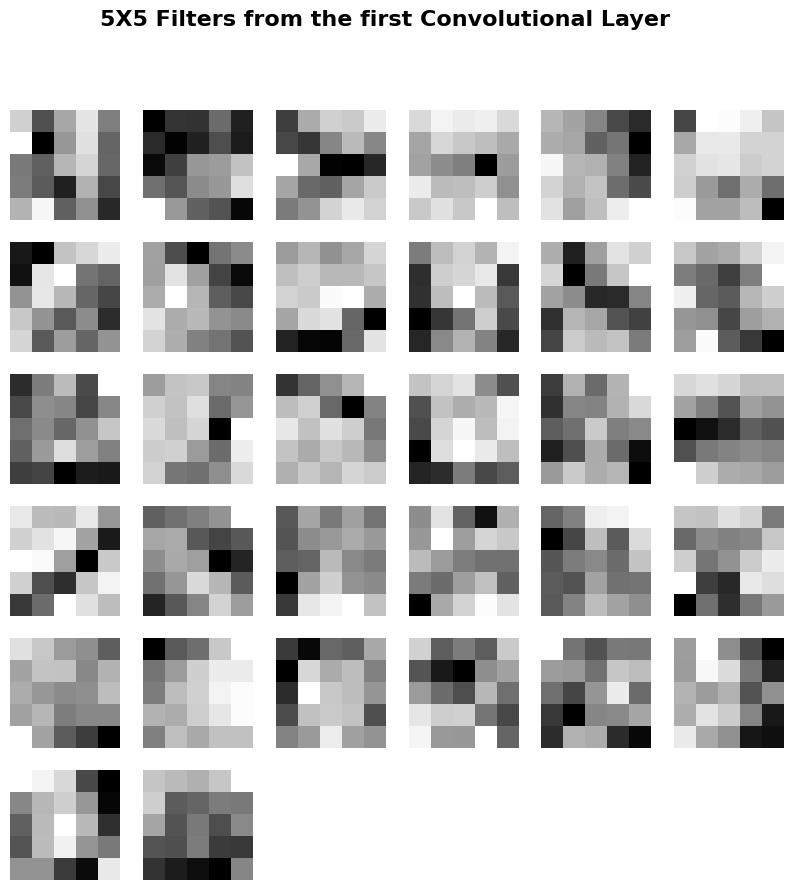

In [48]:
visualize_filters(model, 'conv_stack', 32)
plt.suptitle("5X5 Filters from the first Convolutional Layer", fontsize=16, fontweight='bold')
plt.show()


In [60]:
examples = X_test[y_test == pred][-10:]
labels = y_test[y_test == pred][-10:]


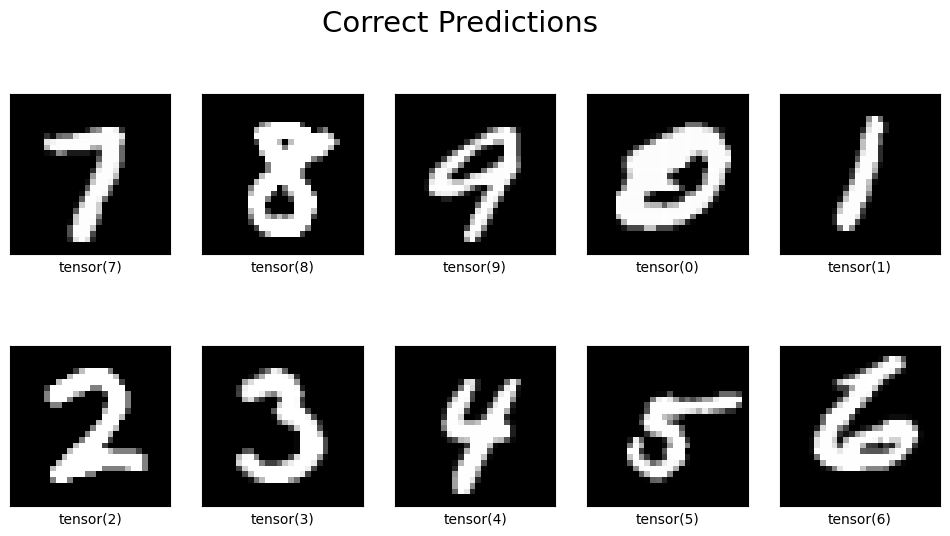

In [61]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(examples[i], cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=labels[i])
plt.suptitle("Correct Predictions", fontsize=21);


In [62]:
wrong_examples = X_test[y_test != pred][10:]
labels = y_test[y_test != pred][10:]
preds = pred[y_test != pred][10:]


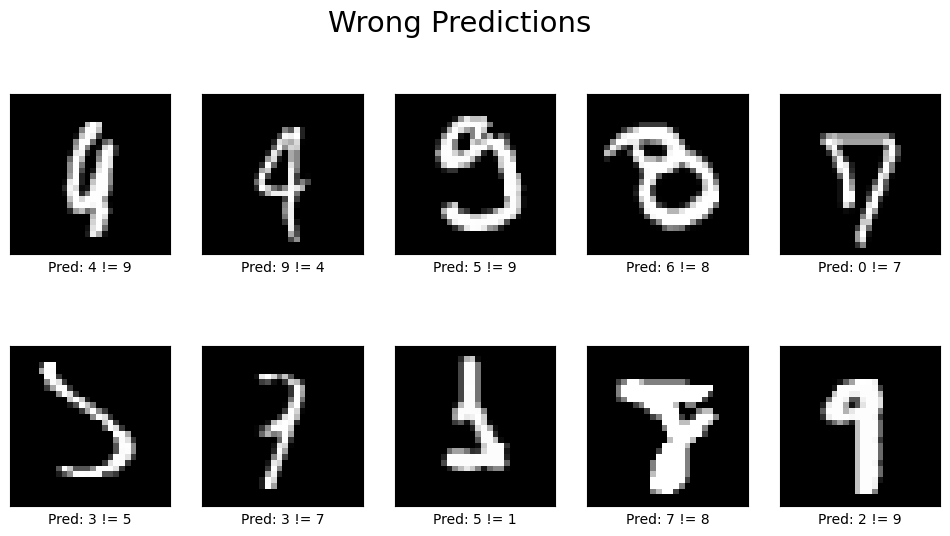

In [63]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(wrong_examples[i], cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=f"Pred: {preds[i]} != {labels[i]}")
plt.suptitle("Wrong Predictions", fontsize=21);


## Conclusion

The accuracy of both models is very similar, while the Neural Network got 97.92% on test, the CNN got 99.01%, but the CNN was much faster to train and the number of parameters is much smaller than the Neural Network. So, the CNN is the best choice for this problem.